# Plot model diagram

In [1]:
from augur.titer_model import TiterCollection
from augur.utils import json_to_tree
import json
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("ticks")
plt.style.use("huddlej")

In [100]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 14

In [18]:
tip_size = 10
end_date = 2004.3

In [48]:
def plot_tree(tree, color_by_trait=None, initial_branch_width=5, tip_size=10,
              start_date=None, end_date=None, include_color_bar=False, ax=None, colorbar_ax=None,
              earliest_node_date=None, default_color="#cccccc", override_y_values=None,
              cmap=None):
    """Plot a BioPython Phylo tree in the BALTIC-style.
    """
    # Plot H3N2 tree in BALTIC style from Bio.Phylo tree.
    if override_y_values is None:
        override_y_values = {}
        
    yvalues = [node.yvalue for node in tree.find_clades()]
    y_span = max(yvalues)
    y_unit = y_span / float(len(yvalues))

    # Setup colors.
    if color_by_trait:
        trait_name = color_by_trait
        
        if cmap is None:
            traits = [k.attr[trait_name] for k in tree.find_clades() if trait_name in k.attr]
            norm = mpl.colors.Normalize(min(traits), max(traits))
            cmap = mpl.cm.viridis

    #
    # Setup the figure grid.
    #

    if ax is None:
        if include_color_bar:
            fig = plt.figure(figsize=(8, 6), facecolor='w')
            gs = gridspec.GridSpec(2, 1, height_ratios=[14, 1], width_ratios=[1], hspace=0.1, wspace=0.1)
            ax = fig.add_subplot(gs[0])
            colorbar_ax = fig.add_subplot(gs[1])
        else:
            fig = plt.figure(figsize=(8, 4), facecolor='w')
            gs = gridspec.GridSpec(1, 1)
            ax = fig.add_subplot(gs[0])

    L=len([k for k in tree.find_clades() if k.is_terminal()])

    # Setup arrays for tip and internal node coordinates.
    tip_circles_x = []
    tip_circles_y = []
    tip_circles_color = []
    tip_circle_sizes = []
    node_circles_x = []
    node_circles_y = []
    node_circles_color = []
    node_line_widths = []
    node_line_segments = []
    node_line_colors = []
    branch_line_segments = []
    branch_line_widths = []
    branch_line_colors = []
    branch_line_labels = []

    for k in tree.find_clades(): ## iterate over objects in tree
        x=k.attr["num_date"] ## or from x position determined earlier
        
        if earliest_node_date and x < earliest_node_date:
            continue
        
        if k.name in override_y_values:
            y = override_y_values[k.name]
        else:
            y = y_span - k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else

        if k.parent is None:
            xp = None
        else:
            xp=k.parent.attr["num_date"] ## get x position of current object's parent

        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c = default_color
        if color_by_trait and trait_name in k.attr:
            if isinstance(cmap, dict):
                c = cmap[k.attr[trait_name]]
            else:
                c = cmap(norm(k.attr[trait_name]))

        branchWidth=2
        if k.is_terminal(): ## if leaf...
            s = tip_size ## tip size can be fixed
            s = (1000 * k.attr.get("projected_frequency", 0.01)) + 1

            tip_circle_sizes.append(s)
            tip_circles_x.append(x)
            tip_circles_y.append(y)
            tip_circles_color.append(c)
        else: ## if node...
            k_leaves = [child
                        for child in k.find_clades()
                        if child.is_terminal()]

            # Scale branch widths by the number of tips.
            branchWidth += initial_branch_width * len(k_leaves) / float(L)

            if len(k.clades)==1:
                node_circles_x.append(x)
                node_circles_y.append(y)
                node_circles_color.append(c)

            ax.plot([x,x],[y_span - k.clades[-1].yvalue, y_span - k.clades[0].yvalue], lw=branchWidth, color=c, ls='-', zorder=9, solid_capstyle='round')

        branch_line_segments.append([(xp, y), (x, y)])
        branch_line_widths.append(branchWidth)
        branch_line_colors.append(c)

    branch_lc = LineCollection(branch_line_segments, zorder=9)
    branch_lc.set_color(branch_line_colors)
    branch_lc.set_linewidth(branch_line_widths)
    branch_lc.set_label(branch_line_labels)
    branch_lc.set_linestyle("-")
    ax.add_collection(branch_lc)

    # Add circles for tips and internal nodes.
    tip_circle_sizes = np.array(tip_circle_sizes)
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*1.75, facecolor="#000000", edgecolor='none', zorder=10) ## plot black circle underneath
    ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

    #ax.set_ylim(-10, y_span - 300)

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])

    if start_date:
        ax.set_xlim(left=start_date)

    if end_date:
        ax.set_xlim(right=end_date)

    if include_color_bar:
        cb1 = mpl.colorbar.ColorbarBase(
            colorbar_ax,
            cmap=cmap,
            norm=norm,
            orientation='horizontal'
        )
        cb1.set_label(color_by_trait)

    return ax, colorbar_ax

## Load tree

In [20]:
with open("../results/auspice/flu_natural_natural_sample_0_with_90_vpm_sliding_2004-04-01_tree.json", "r") as fh:
    tree_json = json.load(fh)

In [21]:
tree = json_to_tree(tree_json)

In [22]:
tree

Clade(branch_length=0, clade=3856, name='NODE_0000002', numdate=1997.869517180294, strain='NODE_0000002', yvalue=2039.144574581474)

In [25]:
tree.root.attr

{'cTiter': 0,
 'cTiterSub': 0.0,
 'clade_membership': '2808be0',
 'clock_length': 0.001,
 'country': 'china',
 'country_confidence': {'china': 0.9449785713212051,
  'hong_kong': 0.053906383886575336},
 'country_entropy': 0.22235035375511555,
 'dTiter': 2.6858171505613497e-08,
 'date': '1997-11-13',
 'delta_frequency': 0.0,
 'div': 0,
 'dms': 0.0,
 'ep': 0,
 'ep_wolf': 0,
 'lbi': 0.05222979501532342,
 'ne': 0,
 'num_date': 1997.869517180294,
 'num_date_confidence': [1997.791847772076, 1997.991998678731],
 'rb': 0,
 'region': 'china',
 'region_confidence': {'china': 0.9965055731758495,
  'southeast_asia': 0.001546531939246032},
 'region_entropy': 0.028736484443005784}

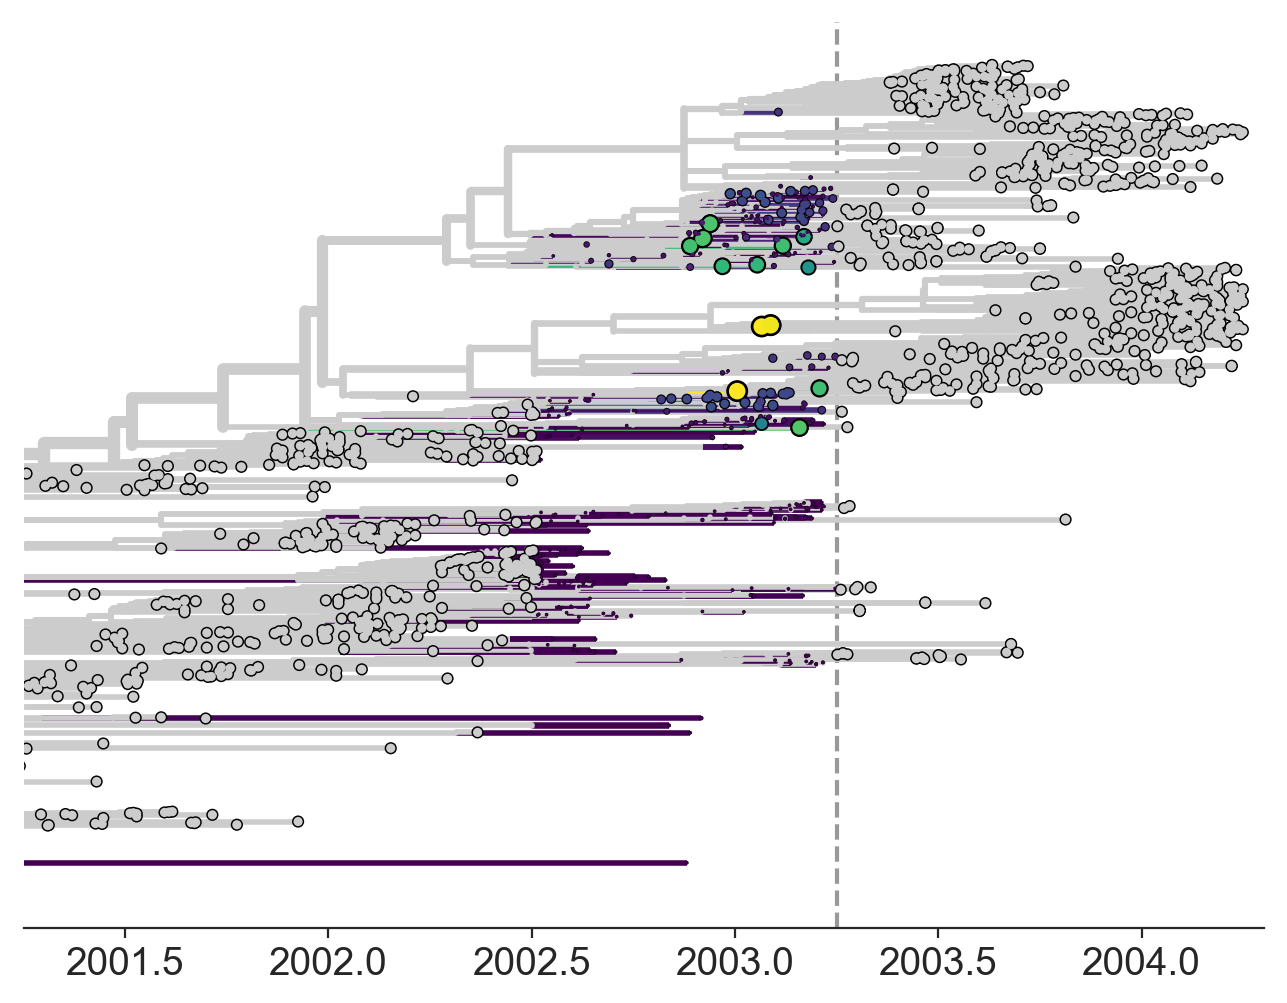

In [52]:
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(tree, color_by_trait="projected_frequency", ax=ax, start_date=2001.25, end_date=end_date, tip_size=tip_size)
ax.axvline(x=2003.25, color="#999999", linestyle="--")

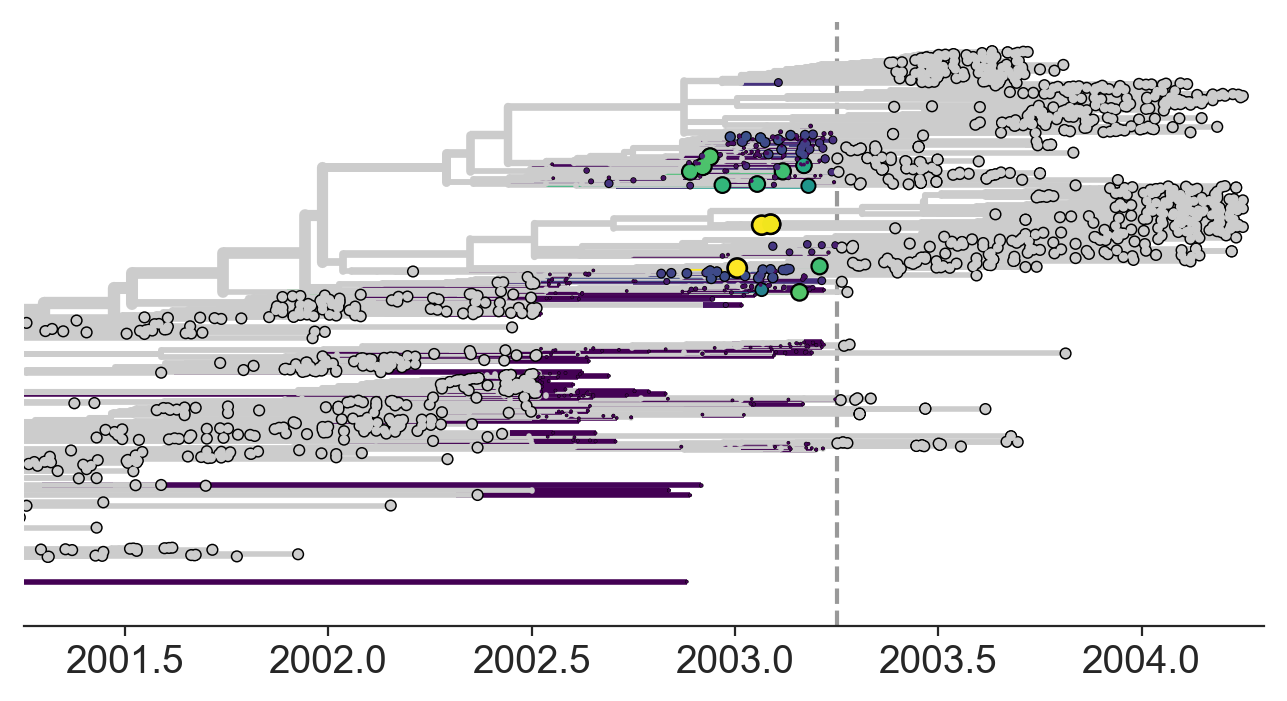

In [110]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(tree, color_by_trait="projected_frequency", ax=ax, start_date=2001.25, end_date=end_date, tip_size=tip_size)
ax.axvline(x=2003.25, color="#999999", linestyle="--")

In [56]:
df = pd.read_csv(
    "../results/builds/natural/natural_sample_0_with_90_vpm_sliding/natural_sample_0_with_90_vpm_sliding_delta_frequency-cTiter-ne_star_forecast.tsv",
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [57]:
df.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,weighted_distance_to_future_by_delta_frequency-cTiter-ne_star,future_timepoint
0,1993-10-01,A/Netherlands/126/1993,0.009072,4.043942,7.439956,-2.324493,1.218509e-04,3.384775,3.384775,1994-10-01
1,1993-10-01,A/Netherlands/165/1993,0.015226,14.252614,17.811164,-7.842640,8.207491e-07,13.773169,13.773169,1994-10-01
2,1993-10-01,A/Netherlands/17/1993,0.000123,6.959802,10.578763,-3.064178,7.884778e-07,6.384514,6.384514,1994-10-01
3,1993-10-01,A/NewYork/754/1993,0.000549,4.924480,8.578773,-3.204311,3.059128e-06,4.384151,4.384151,1994-10-01
4,1993-10-01,A/NewYork/755/1993,0.020792,2.254680,5.600916,0.175177,3.401064e-03,1.382043,1.382043,1994-10-01


In [104]:
x_max = 30
y_max = 300
bins = np.arange(0, x_max + 1, 3)

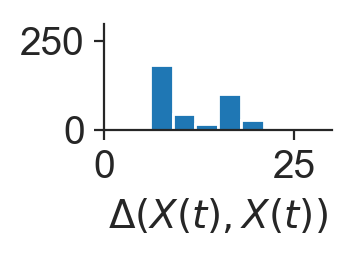

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
ax.hist(df.loc[df["timepoint"] == "2003-04-01", "weighted_distance_to_present"], bins=bins)
ax.set_xlabel("$\Delta(X(t), X(t))$")
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
fig.tight_layout()

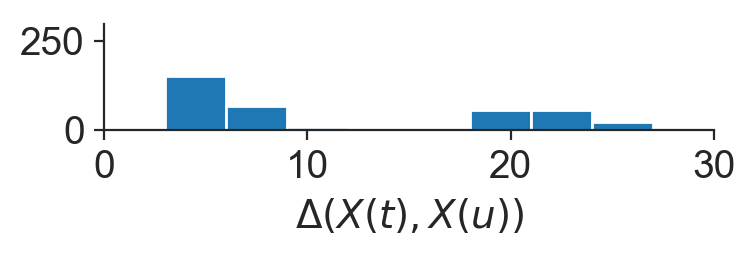

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
ax.hist(df.loc[df["timepoint"] == "2003-04-01", "weighted_distance_to_future"], bins=bins)
ax.set_xlabel("$\Delta(X(t), X(u))$")
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
fig.tight_layout()

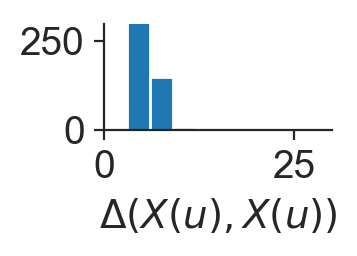

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
ax.hist(df.loc[df["timepoint"] == "2004-04-01", "weighted_distance_to_present"], bins=bins)
ax.set_xlabel("$\Delta(X(u), X(u))$")
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
fig.tight_layout()

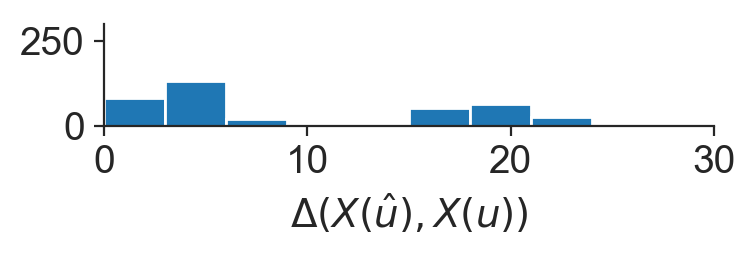

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
ax.hist(df.loc[df["timepoint"] == "2003-04-01", "y"], bins=bins)
ax.set_xlabel("$\Delta(X(\hat{u}), X(u))$")
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
fig.tight_layout()

In [127]:
d_t_u = df.loc[df["timepoint"] == "2003-04-01", "weighted_distance_to_future"].values
d_u_hat_u = df.loc[df["timepoint"] == "2003-04-01", "y"].values
d_u_u = df.loc[df["timepoint"] == "2004-04-01", "weighted_distance_to_present"].values

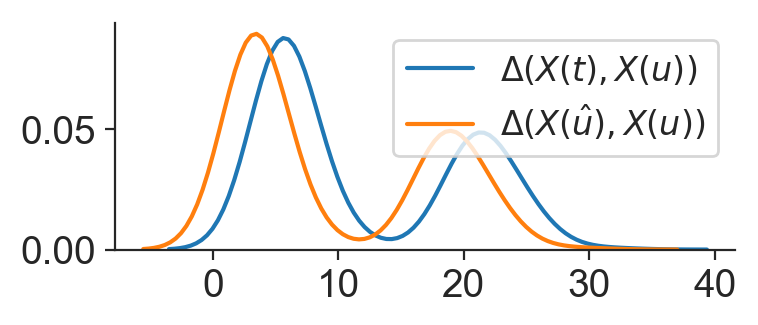

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
sns.distplot(d_t_u, hist=False, ax=ax, label="$\Delta{(X(t), X(u))}$")
sns.distplot(d_u_hat_u, hist=False, ax=ax, label="$\Delta{(X(\hat{u}), X(u))}$")

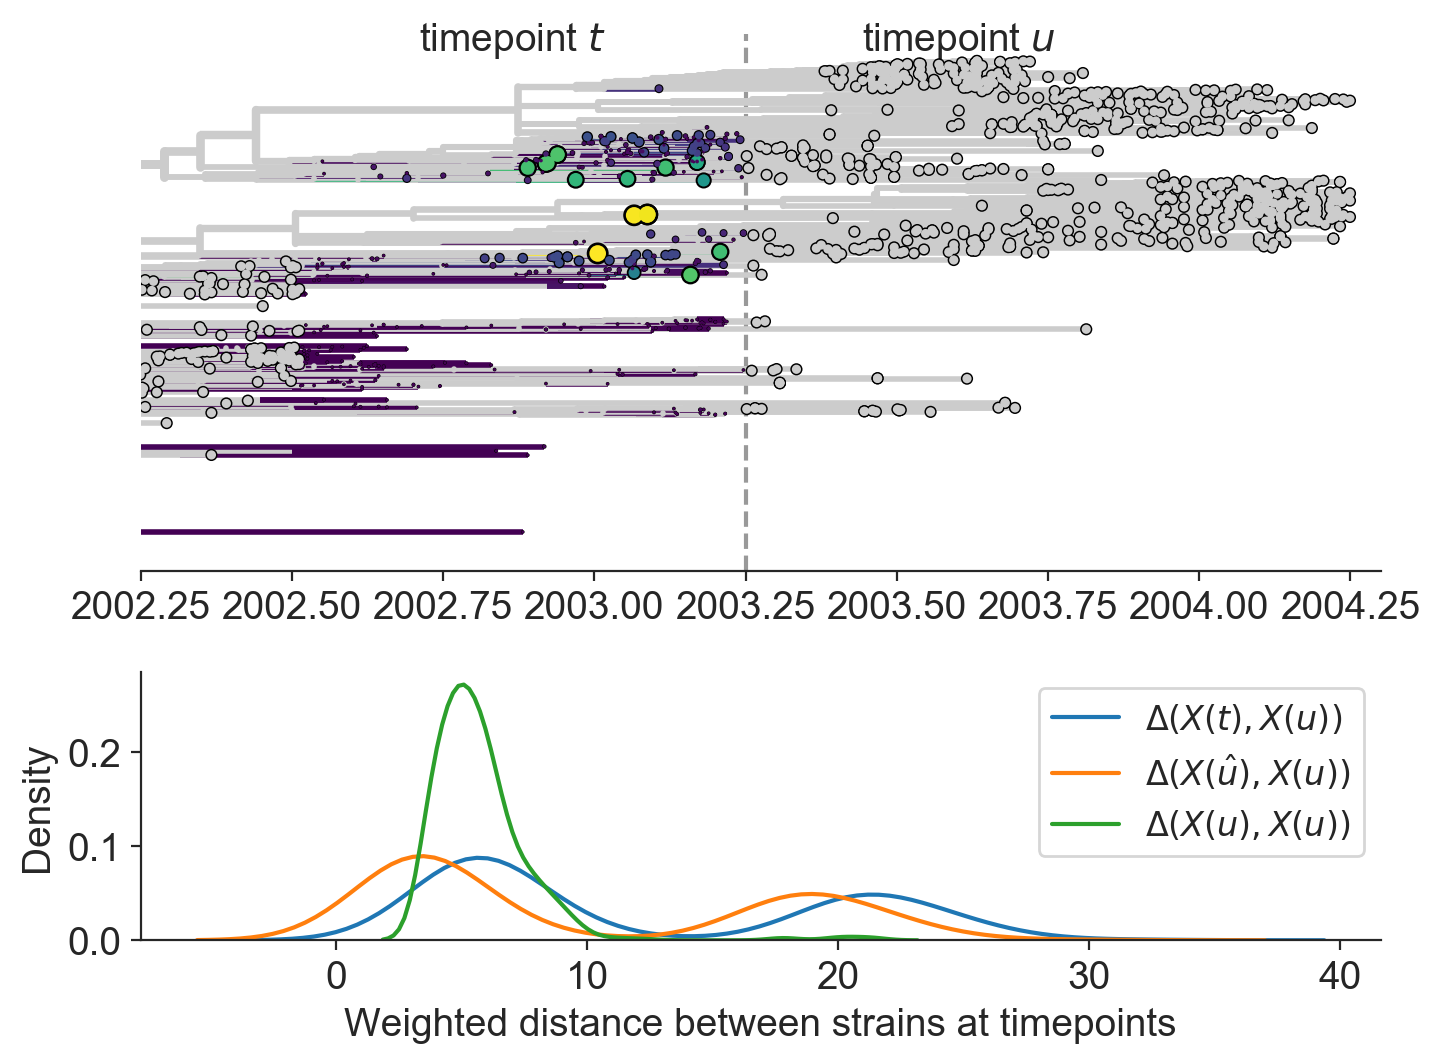

In [146]:
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.5], width_ratios=[1], hspace=0.25, wspace=0.1)

tree_ax = fig.add_subplot(gs[0])    
tree_ax, colorbar_ax = plot_tree(tree, color_by_trait="projected_frequency", ax=tree_ax, start_date=2002.25, end_date=end_date, tip_size=tip_size)
tree_ax.axvline(x=2003.25, color="#999999", linestyle="--")

tree_ax.text(0.3, 0.99, "timepoint $t$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.text(0.66, 0.99, "timepoint $u$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})

density_ax = fig.add_subplot(gs[1])
sns.distplot(d_t_u, hist=False, ax=density_ax, label="$\Delta{(X(t), X(u))}$")
sns.distplot(d_u_hat_u, hist=False, ax=density_ax, label="$\Delta{(X(\hat{u}), X(u))}$")
sns.distplot(d_u_u, hist=False, ax=density_ax, label="$\Delta{(X(u), X(u))}$")
density_ax.set_xlabel("Weighted distance between strains at timepoints")
density_ax.set_ylabel("Density")

plt.savefig("../manuscript/figures/distance-based-fitness-model.png")